# ARMA

If time series data are statonary, we can use ARMA to fit this data.

This notebook explores three models: AR(AutoRegressive), MA(Moving Average), ARMA(Autoregressive–moving-average).

**Absract**:

1. First perform an ADF test, if the time series data are stationary, we can use AR, MA, ARMA models to fit the data.
2. Then plot ACF and PACF to estimate p and q.
3. Train the model.
4. Evaluate predicted values.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller as ADF

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. Data Exploration

In [3]:
from utils import read_bars as read_bars_tmp

# Read bars in May 2020
def read_bars(csv_file: str)->pd.DataFrame:
    # TIME_BEGIN = pd.to_datetime('2020-05-01T00:00:00.000Z').tz_localize(None)
    # TIME_END = pd.to_datetime('2020-06-01T00:00:00.000Z').tz_localize(None)
    TIME_BEGIN = pd.to_datetime('2020-05-12T00:00:00.000Z').tz_localize(None)
    TIME_END = pd.to_datetime('2020-05-14T00:00:00.000Z').tz_localize(None)
    bars_df = read_bars_tmp(csv_file)
    bars_df = bars_df[(bars_df['timestamp'] >= TIME_BEGIN) & (bars_df['timestamp_end'] < TIME_END)]
    return bars_df

In [4]:
time_bars = read_bars('/data/bars/TimeBar/60000/TimeBar.60000.Binance.Swap.BTC_USDT.csv')

In [5]:
time_bars

,exchange,market_type,pair,bar_type,bar_size,timestamp,timestamp_end,open,high,low,...,volume,volume_sell,volume_buy,volume_quote,volume_quote_sell,volume_quote_buy,count,count_sell,count_buy,vwap
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-05-12 00:00:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-12 00:00:00,2020-05-12 00:01:00,8560.730469,8561.879883,8540.769531,...,468.460,226.205,242.255,4005012.0,1933902.50,4004785.80,1060,506,554,8549.314776
2020-05-12 00:01:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-12 00:01:00,2020-05-12 00:02:00,8545.000000,8566.709961,8544.040039,...,321.819,223.273,98.546,2754213.0,1910834.60,2753989.80,904,610,294,8558.267225
2020-05-12 00:02:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-12 00:02:00,2020-05-12 00:03:00,8561.419922,8561.419922,8520.429688,...,519.416,187.146,332.270,4435116.0,1597941.40,4434929.00,1090,422,668,8538.658801
2020-05-12 00:03:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-12 00:03:00,2020-05-12 00:04:00,8534.389648,8548.549805,8534.059570,...,249.244,169.360,79.884,2129134.5,1446641.00,2128965.00,578,352,226,8542.370127
2020-05-12 00:04:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-12 00:04:00,2020-05-12 00:05:00,8543.940430,8570.969727,8542.769531,...,239.320,193.483,45.837,2048108.5,1655730.80,2047915.00,613,453,160,8558.033177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-13 23:54:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-13 23:54:00,2020-05-13 23:55:00,9298.000000,9302.209961,9297.490234,...,76.058,48.657,27.401,707271.4,452464.72,707222.75,209,128,81,9299.105945
2020-05-13 23:55:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-13 23:55:00,2020-05-13 23:56:00,9300.740234,9303.059570,9298.530273,...,74.680,23.799,50.881,694553.2,221346.73,694529.40,195,72,123,9300.391002
2020-05-13 23:56:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-13 23:56:00,2020-05-13 23:57:00,9299.509766,9299.799805,9286.160156,...,786.964,322.447,464.517,7312268.5,2996319.20,7311946.50,839,428,411,9291.744603


### 1.1 Plot price

Text(0.5, 1.0, 'Price')

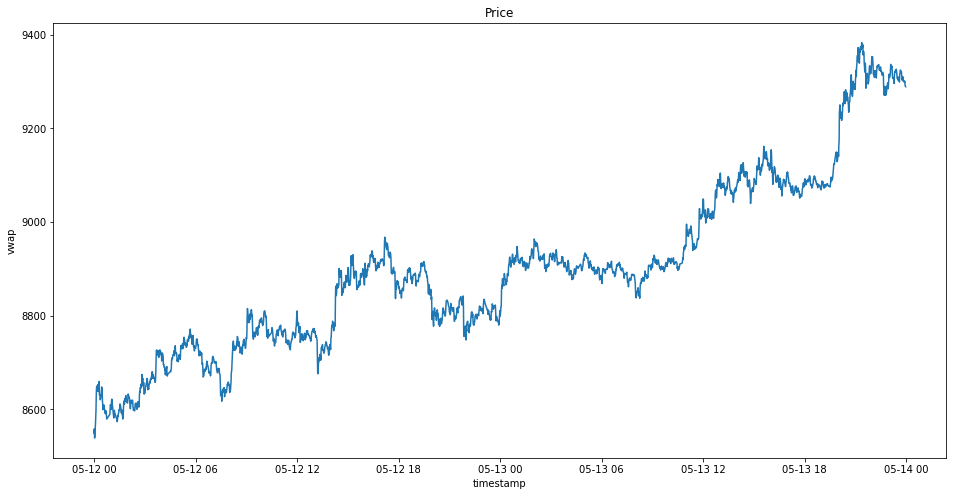

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x=time_bars.index, y=time_bars['vwap'], ax=ax).set_title('Price')

There is a clear trend in the prices above, so the price time series is not stationary.

### 1.2 Plot price diff

In [7]:
price_diffs = time_bars['vwap'].diff().dropna().rename('price_diff')

In [23]:
price_diffs.describe(percentiles=[0.5, 0.95])

count    2803.000000
mean        0.263931
std         7.691363
min       -55.639820
50%         0.132766
95%        12.046110
max        59.946870
Name: price_diff, dtype: float64

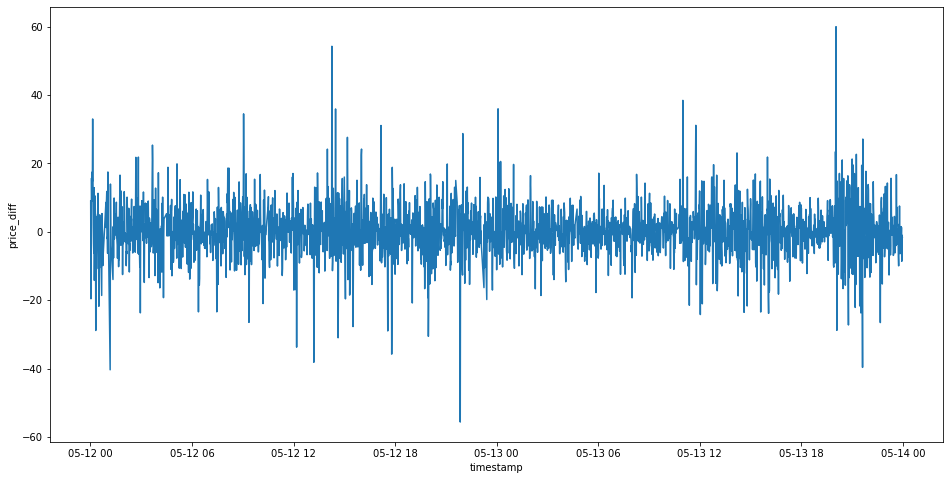

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x=price_diffs.index, y=price_diffs, ax=ax)

### 1.3 ADF test

In [9]:
adf_result = ADF(price_diffs)

In [10]:
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Used lag: %f' % adf_result[2])
print('Number of observations: %f' % adf_result[3])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -25.641372
p-value: 0.000000
Used lag: 4.000000
Number of observations: 2798.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In the output above, we can see that ADF statistic value of `-25.641372` is less than the value of `-3.433` at 1%. Besides, the p-value 0.0 is less than `0.05`. Both values reject the null hypothesis, therefore price diffs are stationary.

## 2. Plot ACF and PACF

Usually we use partial autocorrelation to estimate the order `p` of `AR(p)` model and use autocorrelation to estimate the order `q` of `MA(q)` model, so let's first plot ACF and PACF.

Rules to identify the orders of AR or MA:

* The lag beyond which the PACF cuts off is the indicated order of AR.
* The lag beyond which the ACF cuts off is the indicated order of MA.

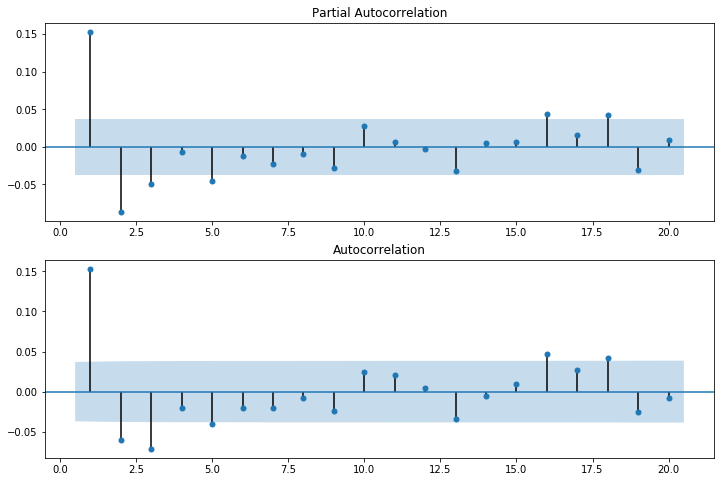

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(price_diffs, lags=20, zero=False, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(price_diffs.values.squeeze(), lags=20, zero=False, ax=ax2)

* The PACF shuts off after lag 1.
* The ACF shuts off after lag 1.

So we can tentatively set `p=1` and `q=1`.

## 2. Train the model

In [12]:
# ValueWarning: A date index has been provided, but it has no associated frequency information
price_diffs.index = pd.DatetimeIndex(price_diffs.index).to_period('T')

In [13]:
# ar1_model = sm.tsa.arima.ARIMA(price_diffs, order=(1, 0, 0)).fit() # AR1
# ma1_model = sm.tsa.arima.ARIMA(price_diffs, order=(0, 0, 1)).fit() # MA1
arma_model = sm.tsa.arima.ARIMA(price_diffs, order=(1, 0, 1)).fit()  # ARMA(1,1)

In [14]:
# arma_model.summary()

In [15]:
print(arma_model.aic, arma_model.bic, arma_model.hqic)

19320.313582579118 19344.067364783776 19328.887322432558


In [16]:
print(arma_model.params)

const      0.264266
ar.L1     -0.124554
ma.L1      0.291327
sigma2    57.520138
dtype: float64


## 3. How dows our model fit the data?

Let's do a white noise test on the residuals time series data. If the residuals are white noise, which means all information have been extracted sufficiently by the model.

### 3.1 Are there any autocorrelations in residuals?

In [17]:
sm.stats.durbin_watson(arma_model.resid.values)

2.004937171210665

The Durbin–Watson statistic is very close to 2, and 2 indicates no autocorrelation.

### 3.2 Plot ACF and PACF of residuals

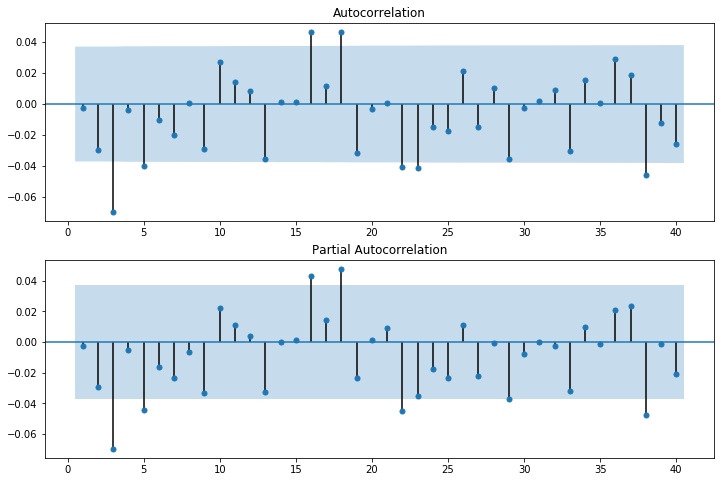

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arma_model.resid.values.squeeze(), lags=40, zero=False, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arma_model.resid, lags=40, zero=False, ax=ax2)

The two figures above show that autocorrelations are very small at almost all lags, which means residuals are almost white noise, the model has extracted information sufficiently.

### 3.3 Ljung-Box test

In [19]:
sm.stats.acorr_ljungbox(arma_model.resid.values, lags=1, return_df=True)

,lb_stat,lb_pvalue
1,0.020709,0.885574


The p-value of Ljung-Box test is much greater than 0.05, which indicates that residuals are white noise.

**Conclusion: The residuals are white noise, which means our model fits the data quite well.**

## 4. Plot predicted values

In [20]:
index_begin = int(price_diffs.shape[0] * 0.8)
index_end = int(price_diffs.shape[0] * 0.82)

In [21]:
predicted_price_diffs = arma_model.predict(
    start=index_begin,
    end=index_end,
    dynamic=True,
)

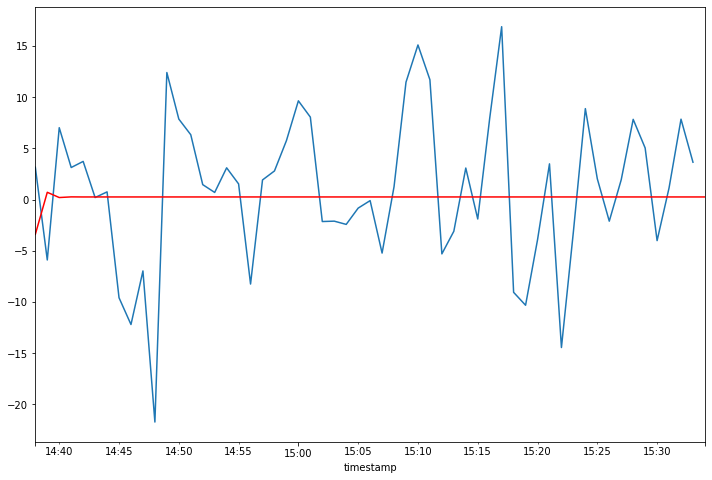

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
price_diffs[index_begin: index_end].plot(ax=ax)
predicted_price_diffs.plot(ax=ax, style='r')

## Lessions Learnt

* <font color='red'>AR, MA, ARMA and ARIMA require time series data to have a constant time interval.</font> Only time bar can be used, tick bar, volume bar and dollar bar have no constant time intervals.

## References

* [Everything you can do with a time series | Kaggle](https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series)
* [Time Series Forecast Case Study with Python: Monthly Armed Robberies in Boston](https://machinelearningmastery.com/time-series-forecast-case-study-python-monthly-armed-robberies-boston/)
* [How does ACF & PACF identify the order of MA and AR terms? - Cross Validated](https://stats.stackexchange.com/q/281666/21732)
* [Rules for identifying ARIMA models](https://people.duke.edu/~rnau/arimrule.htm)
* [Identifying the numbers of AR or MA terms in an ARIMA model](https://people.duke.edu/~rnau/411arim3.htm)
* [Autoregressive–moving-average model - Wikipedia](https://en.wikipedia.org/wiki/Autoregressive–moving-average_model)
* [Autoregressive Moving Average (ARMA): Sunspots data - statsmodels](https://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html)
* [statsmodels.tsa.arima.model.ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html)